In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Specify training data directory
XRay_Directory = '/content/drive/MyDrive/FIU/OpenCV/Mangroves/Dataset'

In [6]:
# List the folders in the directory
os.listdir(XRay_Directory)

['2', '1', '0']

In [7]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [8]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(50,50), class_mode = 'categorical', subset="training")


Found 216 images belonging to 3 classes.


In [9]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(50,50), class_mode = 'categorical', subset="validation")


Found 54 images belonging to 3 classes.


In [10]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)


In [11]:
train_images.shape

(40, 50, 50, 3)

In [12]:
train_labels.shape

(40, 3)

In [13]:
train_labels

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [14]:
# labels Translator 
label_names = {0 : 'River', 1 : 'Boundary', 2 : 'Mangrove'}

# VISUALIZE DATASET

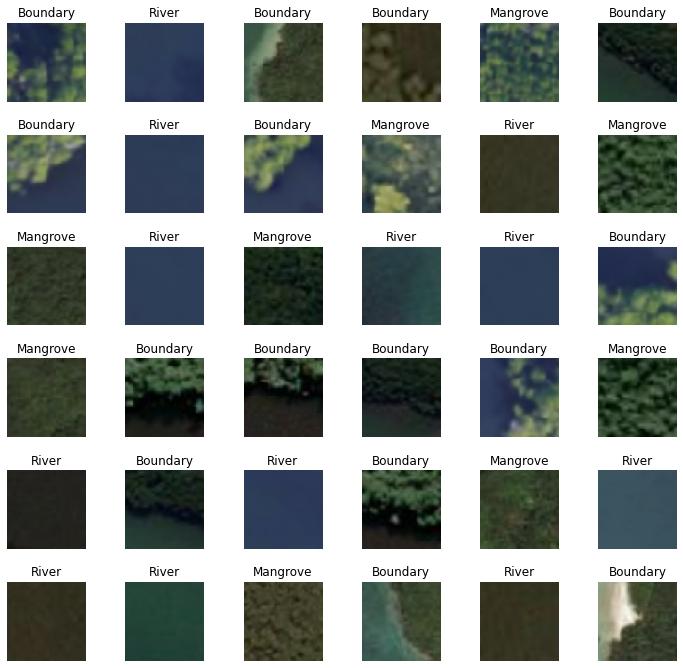

In [15]:
# Create a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    

# IMPORT MODEL WITH PRETRAINED WEIGHTS

In [16]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(50,50,3)))

94781440/94765736 [==============================] - 2s 0us/step


In [17]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 56, 56, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 25, 25, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 25, 25, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [18]:
#freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layers.trainable = False

# BUILD AND TRAIN DEEP LEARNING MODEL

In [19]:
headmodel = basemodel.output
#headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(16, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(8, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [20]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics= ["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [21]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [22]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(50,50), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(50,50), class_mode= 'categorical', subset="validation")

Found 216 images belonging to 3 classes.
Found 54 images belonging to 3 classes.


In [23]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 150, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
54/54 [==============================] - 139s 2s/step - loss: 1.0220 - accuracy: 0.4907 - val_loss: 1.1074 - val_accuracy: 0.3462

Epoch 00001: val_loss improved from inf to 1.10741, saving model to weights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/150
54/54 [==============================] - 6s 102ms/step - loss: 0.8554 - accuracy: 0.5833 - val_loss: 1.3204 - val_accuracy: 0.3269

Epoch 00002: val_loss did not improve from 1.10741
Epoch 3/150
54/54 [==============================] - 5s 100ms/step - loss: 0.6209 - accuracy: 0.7176 - val_loss: 2.0730 - val_accuracy: 0.3269

Epoch 00003: val_loss did not improve from 1.10741
Epoch 4/150
54/54 [==============================] - 5s 100ms/step - loss: 0.6311 - accuracy: 0.6898 - val_loss: 6.7223 - val_accuracy: 0.3077

Epoch 00004: val_loss did not improve from 1.10741
Epoch 5/150
54/54 [==============================] - 5s 99ms/step - loss: 0.5556 - accuracy: 0.7593 - val_loss: 11.9471 - val_accuracy: 0.3462

Epoch 00005: val_loss did not improve from 1.10741
Epoch 6/150
54/54 [==============================] - 5s 101ms/step - loss: 0.6613 - accuracy: 0.6944 - val_loss: 6.8797 - val_accuracy: 0.3077

Epoch 00006: val_loss did not improve from 1.10741
Epoch 7/150
54/54 [======

# EVALUATE TRAINED DEEP LEARNING MODEL

In [ ]:
history.history.keys()

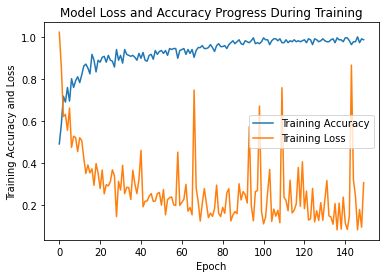

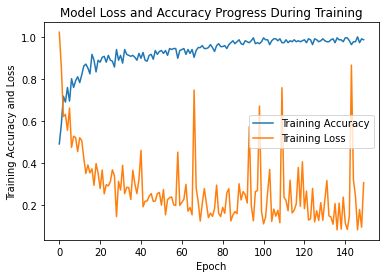

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])

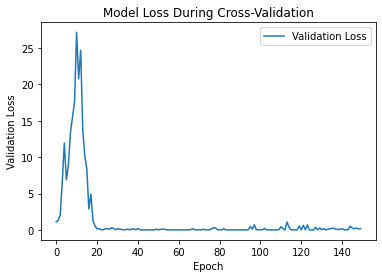

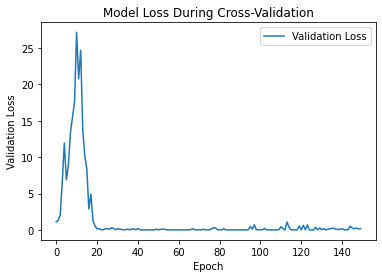

In [26]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])

In [ ]:
test_directory = '/content/drive/MyDrive/FIU/OpenCV/Mangroves/Test'


In [29]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 4, directory= test_directory, shuffle= True, target_size=(50,50), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 3, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 27 images belonging to 3 classes.
Found 27 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


9/9 [==============================] - 11s 1s/step - loss: 2.1010 - accuracy: 0.9259
Accuracy Test : 0.9259259104728699
Accuracy Test : 0.9259259104728699


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(50,50))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,50,50,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [ ]:
len(original)

In [ ]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

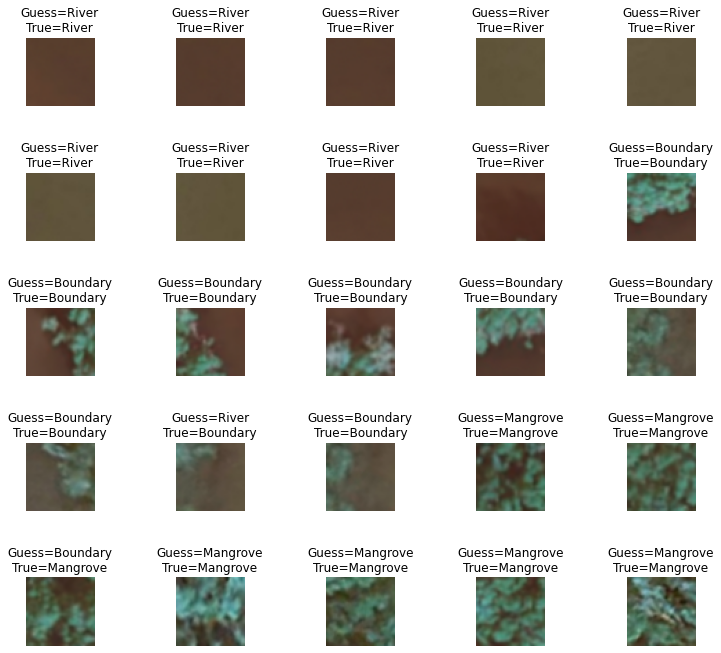

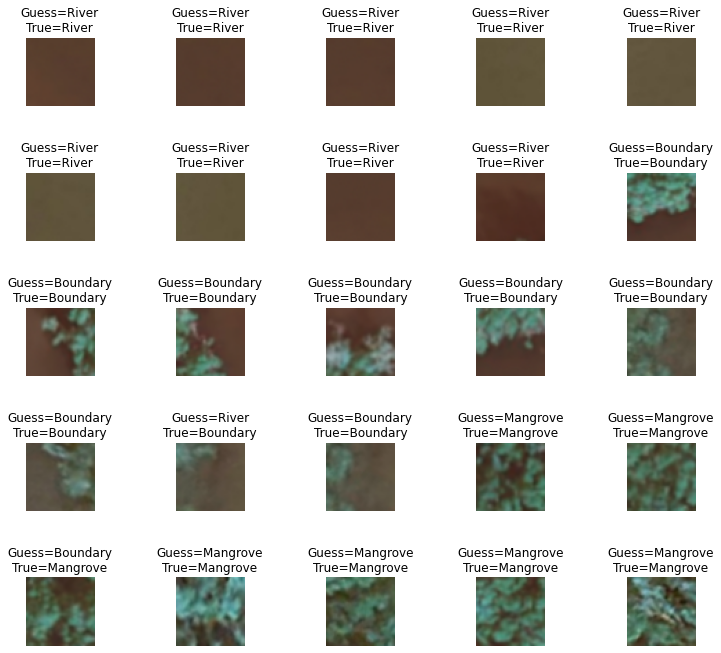

In [33]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

Text(0.5, 1.0, 'Confusion_matrix')

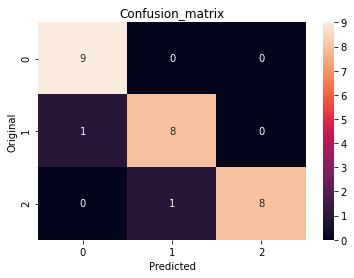

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')